# Solution to DPS Challenge June 2022

This ipynb contains my submission to DPS challenge of 2022. 

# Data loading

In [36]:
# !pip install pmdarima
# !pip install pycaret --user
# !pip install 'Jinja2'
# !pip install markupsafe==2.0.1
# !pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pickle
import chardet
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
import matplotlib.pyplot as plt

import lightgbm as lgb

from tqdm import tqdm 
tqdm.pandas()

# working_directory = os.getcwd()
# print(working_directory)

In [3]:
# Alternative on Google Drive
from google.colab import drive 
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
BASE_PATH = './'
# BASE_PATH = '/content/drive/MyDrive/DPS/'
file_name = '220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv'
file_path = BASE_PATH + file_name

In [4]:
def get_file_encoding(file_name):
    with open(file=file_name, mode='rb') as inp:
        encoding= chardet.detect(inp.read(10000))['encoding']
    return encoding

In [5]:
df = pd.read_csv(file_path, sep=',', encoding=get_file_encoding(file_path))

In [6]:
df.shape

(2086, 9)

# EDA

In [9]:
df.head(5)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2000,Summe,934.0,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2000,200001,78.0,NaN,NaN,NaN,78.0
2,Alkoholunfälle,insgesamt,2000,200002,53.0,NaN,-32.05,NaN,66.0
3,Alkoholunfälle,insgesamt,2000,200003,73.0,NaN,37.74,NaN,68.0
4,Alkoholunfälle,insgesamt,2000,200004,78.0,NaN,6.85,NaN,71.0


In [10]:
df.columns

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'],
      dtype='object')

In [11]:
df.MONATSZAHL.unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

In [12]:
df.AUSPRAEGUNG.unique()

array(['insgesamt', 'Verletzte und Getötete', 'mit Personenschäden'],
      dtype=object)

In [13]:
df.JAHR.nunique()

23

In [14]:
df.MONAT.nunique()

277

In [15]:
df.WERT.isna().sum()

84

In [6]:
df[df.MONAT == 'Summe'].shape

(154, 9)

<AxesSubplot:xlabel='JAHR'>

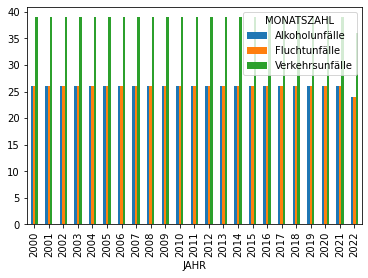

In [39]:
pd.crosstab(df['JAHR'],df['MONATSZAHL']).plot.bar()

<AxesSubplot:xlabel='JAHR', ylabel='count'>

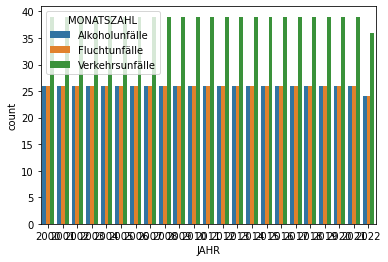

In [37]:
import seaborn as sns
sns.countplot(data=df,x='JAHR',hue='MONATSZAHL')

<AxesSubplot:xlabel='JAHR'>

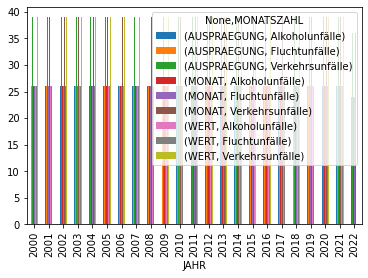

In [40]:
pd.pivot_table(df,index = 'JAHR',
               columns = 'MONATSZAHL',aggfunc ='count').plot.bar()

In [17]:
df.MONATSZAHL.unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

# Data Pre-Processing

In [14]:
important_columns = ['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT']
df = df[important_columns]

In [18]:
df.isna().sum()

MONATSZAHL      0
AUSPRAEGUNG     0
JAHR            0
MONAT           0
WERT           84
dtype: int64

In [19]:
df.dropna(inplace=True)

In [20]:
df.shape

(2002, 5)

In [21]:
# filtering on MONATSZAHL and AUSPRAEGUNG
df = df[(df.MONATSZAHL == 'Alkoholunfälle') & (df.AUSPRAEGUNG == 'insgesamt')]

In [22]:
# removing Summe values from MONAT
df = df[df.MONAT != 'Summe']

In [23]:
def split_month(monat_entry):
    _, month_field = monat_entry[0:4], monat_entry[4:]
    return pd.Series([month_field])

df[['MONAT']] = df.MONAT.progress_apply(split_month)

100%|██████████| 264/264 [00:00<00:00, 4041.57it/s]


In [24]:
df.head(5)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
1,Alkoholunfälle,insgesamt,2000,01,78.0
2,Alkoholunfälle,insgesamt,2000,02,53.0
3,Alkoholunfälle,insgesamt,2000,03,73.0
4,Alkoholunfälle,insgesamt,2000,04,78.0
5,Alkoholunfälle,insgesamt,2000,05,96.0


In [25]:
working_df = df[df.JAHR <= 2020]
ground_truth_df = df[df.JAHR > 2020]
working_df.shape, ground_truth_df.shape

((252, 5), (12, 5))

# Visualization

# Statistical Testing

## The reason behind this statistical testing

As the data is based on alcohol related accidents, I have a hypothesis that there could be a seasonal pattern in the data. Because, as alcohol keeps our body warm, people might tend to consume more alcohol during the winter period, which will lead to an increased amount of accidents due to alcohol consumption. In order to test this hypothesis, I resort to Augmented Dickey Fuller test for stationarity in the data. The null hypothesis of this test assumes there is no stationarity in the data. Should we fail to reject this null hypothesis, we can conclude that there **could be** a season pattern in the data.

In [26]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(working_df[['WERT']].to_numpy().reshape(-1), autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -2.778474              Test Statistics
1    0.061415                      p-value
2   13.000000             No. of lags used
3  238.000000  Number of observations used
4   -3.458128          critical value (1%)
5   -2.873762          critical value (5%)
6   -2.573283         critical value (10%)


We can see that our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value. We can also draw these conclusions from inspecting the data, as we see a clear, increasing trend in the WERT.

In [ ]:
import matplotlib.pyplot as plt


rolling_mean = df[['WERT']].rolling(5).mean()
rolling_std = df[['WERT']].rolling(5).std()
plt.plot(df[['WERT']], color="blue",label="Original # Accidents")
plt.plot(rolling_mean, color="red", label="Rolling Mean # Accidents")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in # Accidents")
plt.title("Accidents Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

# Statistical Modeling

In [17]:
working_df.WERT

1       78.0
2       53.0
3       73.0
4       78.0
5       96.0
        ... 
1828    46.0
1829    46.0
1830    34.0
1831    23.0
1832    13.0
Name: WERT, Length: 252, dtype: float64

In [27]:
from pmdarima.arima import auto_arima

model = auto_arima(working_df.WERT, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(working_df.WERT)
forecast = model.predict(n_periods=len(ground_truth_df.WERT))
forecast = pd.DataFrame(forecast,index = ground_truth_df.WERT.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1927.066, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1997.543, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1959.851, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1956.164, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1995.645, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1960.127, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1925.567, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1927.558, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1958.829, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1925.646, Time=0.40 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1960.820, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1929.547, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1927.933, Time=0.25 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 3.472 seconds


In [28]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

rms = sqrt(mean_squared_error(ground_truth_df.WERT, forecast))
mae = mean_absolute_error(ground_truth_df.WERT, forecast)
print("RMSE: ", rms)
print('MAE: ', mae)

RMSE:  13.404901991527572
MAE:  11.735611603881194


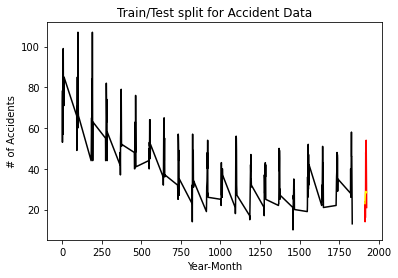

In [29]:
import seaborn as sns 

plt.plot(working_df.WERT, color = "black")
plt.plot(ground_truth_df.WERT, color = "red")
plt.plot(forecast, color = "yellow")
plt.title("Train/Test split for Accident Data")
plt.ylabel("# of Accidents")
plt.xlabel('Year-Month')
sns.set()
plt.show()

# Machine Learning Model for prediction

### Model Selection

In [31]:
import jinja2
from pycaret.regression import *
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(working_df[['JAHR', 'MONAT', 'WERT']], test_size=0.2)
s = setup(data = train_df, test_data = test_df, target = 'WERT', numeric_features = ['JAHR', 'MONAT'], fold = 5, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,WERT
2,Original Data,"(201, 3)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(201, 2)"


In [32]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,6.5355,73.7452,8.5532,0.7472,0.1989,0.1618,0.086
gbr,Gradient Boosting Regressor,6.7798,78.5957,8.8090,0.7347,0.2150,0.1674,0.044
rf,Random Forest Regressor,6.7907,78.1552,8.8243,0.7336,0.2048,0.1688,0.228
knn,K Neighbors Regressor,6.8922,77.0560,8.7154,0.7374,0.2064,0.1725,0.078
et,Extra Trees Regressor,7.1532,89.6916,9.4177,0.7018,0.2213,0.1754,0.166
ada,AdaBoost Regressor,7.5240,95.2920,9.7264,0.6690,0.2243,0.1855,0.058
dt,Decision Tree Regressor,9.1780,135.0483,11.5956,0.5447,0.2754,0.2304,0.020
lar,Least Angle Regression,9.8919,157.2233,12.5101,0.4638,0.2985,0.2577,0.018
lr,Linear Regression,9.8919,157.2240,12.5101,0.4638,0.2985,0.2577,0.590
ridge,Ridge Regression,9.8920,157.2260,12.5102,0.4638,0.2985,0.2577,0.018


In [33]:
best = compare_models(sort = 'MSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,6.5355,73.7452,8.5532,0.7472,0.1989,0.1618,0.028
knn,K Neighbors Regressor,6.8922,77.0560,8.7154,0.7374,0.2064,0.1725,0.078
rf,Random Forest Regressor,6.7907,78.1552,8.8243,0.7336,0.2048,0.1688,0.236
gbr,Gradient Boosting Regressor,6.7798,78.5957,8.8090,0.7347,0.2150,0.1674,0.044
et,Extra Trees Regressor,7.1532,89.6916,9.4177,0.7018,0.2213,0.1754,0.172
ada,AdaBoost Regressor,7.5240,95.2920,9.7264,0.6690,0.2243,0.1855,0.058
dt,Decision Tree Regressor,9.1780,135.0483,11.5956,0.5447,0.2754,0.2304,0.018
lar,Least Angle Regression,9.8919,157.2233,12.5101,0.4638,0.2985,0.2577,0.020
lr,Linear Regression,9.8919,157.2240,12.5101,0.4638,0.2985,0.2577,0.024
ridge,Ridge Regression,9.8920,157.2260,12.5102,0.4638,0.2985,0.2577,0.018


In [34]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,6.5355,73.7452,8.5532,0.7472,0.1989,0.1618,0.026
knn,K Neighbors Regressor,6.8922,77.0560,8.7154,0.7374,0.2064,0.1725,0.076
gbr,Gradient Boosting Regressor,6.7798,78.5957,8.8090,0.7347,0.2150,0.1674,0.044
rf,Random Forest Regressor,6.7907,78.1552,8.8243,0.7336,0.2048,0.1688,0.236
et,Extra Trees Regressor,7.1532,89.6916,9.4177,0.7018,0.2213,0.1754,0.198
ada,AdaBoost Regressor,7.5240,95.2920,9.7264,0.6690,0.2243,0.1855,0.060
dt,Decision Tree Regressor,9.1780,135.0483,11.5956,0.5447,0.2754,0.2304,0.018
lar,Least Angle Regression,9.8919,157.2233,12.5101,0.4638,0.2985,0.2577,0.018
lr,Linear Regression,9.8919,157.2240,12.5101,0.4638,0.2985,0.2577,0.020
ridge,Ridge Regression,9.8920,157.2260,12.5102,0.4638,0.2985,0.2577,0.020


### Model training and hyperparameter tuning with NestedCV

In [159]:
from pandas import concat, DataFrame

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """

  n_vars = 1 if type(data) is list else data.shape[1]
  print(n_vars)
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg


# values = [x for x in range(10)]

working_df = pd.read_csv(BASE_PATH+'working_df.csv', sep=',', header=None, index_col=0, encoding='utf-8')
working_df.columns = important_columns
working_df = working_df.reset_index(drop=True)
data = series_to_supervised(working_df.WERT.tolist())
data

1


,var1(t-1),var1(t)
1,78.0,53
2,53.0,73
3,73.0,78
4,78.0,96
5,96.0,57
...,...,...
247,58.0,46
248,46.0,46
249,46.0,34
250,34.0,23


In [41]:
working_df

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
1,Alkoholunfälle,insgesamt,2000,01,78.0
2,Alkoholunfälle,insgesamt,2000,02,53.0
3,Alkoholunfälle,insgesamt,2000,03,73.0
4,Alkoholunfälle,insgesamt,2000,04,78.0
5,Alkoholunfälle,insgesamt,2000,05,96.0
...,...,...,...,...,...
1828,Alkoholunfälle,insgesamt,2020,08,46.0
1829,Alkoholunfälle,insgesamt,2020,09,46.0
1830,Alkoholunfälle,insgesamt,2020,10,34.0
1831,Alkoholunfälle,insgesamt,2020,11,23.0


In [77]:
start = time()

model_to_tune = lgb.LGBMRegressor(
    boosting_type = 'gbdt',
    objective = 'regression',
    n_jobs= -1,
    random_state=42)

param_grid = {
    'learning_rate': [0.005, 0.05, 0.01],
    'max_depth': [15, 20],
    'num_leaves': [50, 100],
    'n_estimators': [100, 1000],
    'reg_alpha': [0.001, 0.01]
}

mae_scores = list()
outer_cv = RepeatedKFold(n_splits=5, n_repeats=5)
i = 0
for train_val_index, test_index in outer_cv.split(working_df[['JAHR', 'MONAT', 'WERT']].to_numpy()):
  
  X_train_val = working_df[['JAHR', 'MONAT']].to_numpy()[train_val_index]
  Y_train_val = working_df[['WERT']].to_numpy().reshape(-1)[train_val_index]
  X_test = working_df[['JAHR', 'MONAT']].to_numpy()[test_index]
  Y_test = working_df[['WERT']].to_numpy()[test_index]

  inner_cv = RepeatedKFold(n_splits=5, n_repeats=5)
  clf = GridSearchCV(estimator = model_to_tune, cv = inner_cv, refit=True, param_grid=param_grid)
  result = clf.fit(X_train_val, Y_train_val)
  best_model = result.best_estimator_
  Y_pred = best_model.predict(X_test)
  score = mean_absolute_error(Y_test, Y_pred)
  mae_scores.append(score)
  print('>mae=%.4f, est=%.4f, cfg=%s' % (score, result.best_score_, result.best_params_))
  with open(BASE_PATH + 'models/model_'+ str(i) + '_' + str(score)+'.pickle', 'wb') as handle:
    pickle.dump(best_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
  i += 1
print('MAE: %.3f (%.3f)' % (np.mean(mae_scores), np.std(mae_scores)))
end = time()
print("Fit Time:", end - start)

>mae=6.7098, est=0.7419, cfg={'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.001}
>mae=6.8284, est=0.7563, cfg={'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.001}
>mae=6.7070, est=0.7435, cfg={'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.001}
>mae=7.4311, est=0.7656, cfg={'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.01}
>mae=5.2185, est=0.7320, cfg={'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.01}
>mae=5.9800, est=0.7410, cfg={'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.001}
>mae=7.3336, est=0.7740, cfg={'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.01}
>mae=7.3066, est=0.7475, cfg={'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000, '

In [ ]:
# best performant model
# mae=4.9385, est=0.7304, cfg={'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 1000, 'num_leaves': 50, 'reg_alpha': 0.001}

# Generalization Error with Ground Truth Data

In [86]:
best_model = 'model_0_4.938540395890729.pickle'
with open(BASE_PATH+'models/'+best_model, 'rb') as f:
  model = pickle.load(f)

y_preds = model.predict(ground_truth_df[['JAHR', 'MONAT']].to_numpy())
mean_absolute_error(ground_truth_df.WERT.to_numpy().reshape(-1), y_preds)

8.732374065957297